In [14]:
import sys
sys.path.insert(0, '..')

In [32]:
from pyphoon.db import pd_manager
import pandas as pd

In [16]:
orig_images_dir = '../../../../datasets/typhoon/wnp/image/'
corrected_dir = '../../../database/corrected'
db_dir = '../../../database/'

In [17]:
from os.path import exists, join
images = join(db_dir, 'images.pkl')
corrupted = join(db_dir, 'corrupted.pkl')

In [18]:
pd_man = pd_manager.PDManager()
pd_man.load_images(images)
pd_man.load_corrupted(corrupted)

In [19]:
joined = pd_man.images.join(pd_man.corrupted, how='inner')

In [20]:
joined.head()

directory                     filename    size  \
seq_no obs_time                                                             
197901 1979-01-03 16:00:00    197901  1979010316-197901-GMS1-1.h5  282481   
       1979-01-06 21:00:00    197901  1979010621-197901-GMS1-1.h5  254187   
       1979-01-07 06:00:00    197901  1979010706-197901-GMS1-1.h5  256038   
197902 1979-03-22 03:00:00    197902  1979032203-197902-GMS1-1.h5  242027   
       1979-03-22 06:00:00    197902  1979032206-197902-GMS1-1.h5  242848   

                                    corrupted  corruption  
seq_no obs_time                                            
197901 1979-01-03 16:00:00  197901_1979010316    0.969746  
       1979-01-06 21:00:00  197901_1979010621    0.879063  
       1979-01-07 06:00:00  197901_1979010706    0.871773  
197902 1979-03-22 03:00:00  197902_1979032203    0.000328  
       1979-03-22 06:00:00  197902_1979032206    0.000103

In [33]:
import matplotlib.pyplot as plt

In [34]:
%matplotlib inline

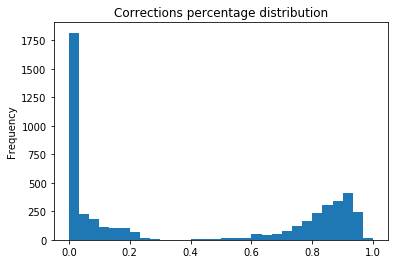

In [39]:
pd_man.corrupted.corruption.plot.hist(bins=30, title='Corrections percentage distribution')

## Discard slightly corrected images

In [41]:
discard_less_than = 0.01
signif_cor = pd_man.corrupted.loc[pd_man.corrupted.corruption >= discard_less_than, :]

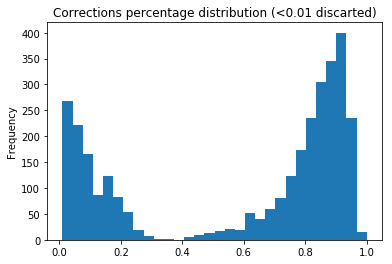

In [58]:
signif_cor.corruption.plot.hist(bins=30, title=('Corrections percentage distribution (<{0} discarted)').format(discard_less_than))

In [123]:
signif_cor.corruption.describe()

count    3181.000000
mean        0.596200
std         0.357481
min         0.010029
25%         0.156578
50%         0.792988
75%         0.888710
max         1.000000
Name: corruption, dtype: float64

In [127]:
bins = np.linspace(0, 1, num=30, endpoint=True)

In [128]:
bins

array([ 0.        ,  0.03448276,  0.06896552,  0.10344828,  0.13793103,
        0.17241379,  0.20689655,  0.24137931,  0.27586207,  0.31034483,
        0.34482759,  0.37931034,  0.4137931 ,  0.44827586,  0.48275862,
        0.51724138,  0.55172414,  0.5862069 ,  0.62068966,  0.65517241,
        0.68965517,  0.72413793,  0.75862069,  0.79310345,  0.82758621,
        0.86206897,  0.89655172,  0.93103448,  0.96551724,  1.        ])

In [130]:

signif_cor['bins']=pd.cut(bins=bins, x=signif_cor.corruption)

/fs9/grishin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [132]:
binned = signif_cor.groupby(signif_cor.bins)

In [139]:
largest = binned.size().argmax()

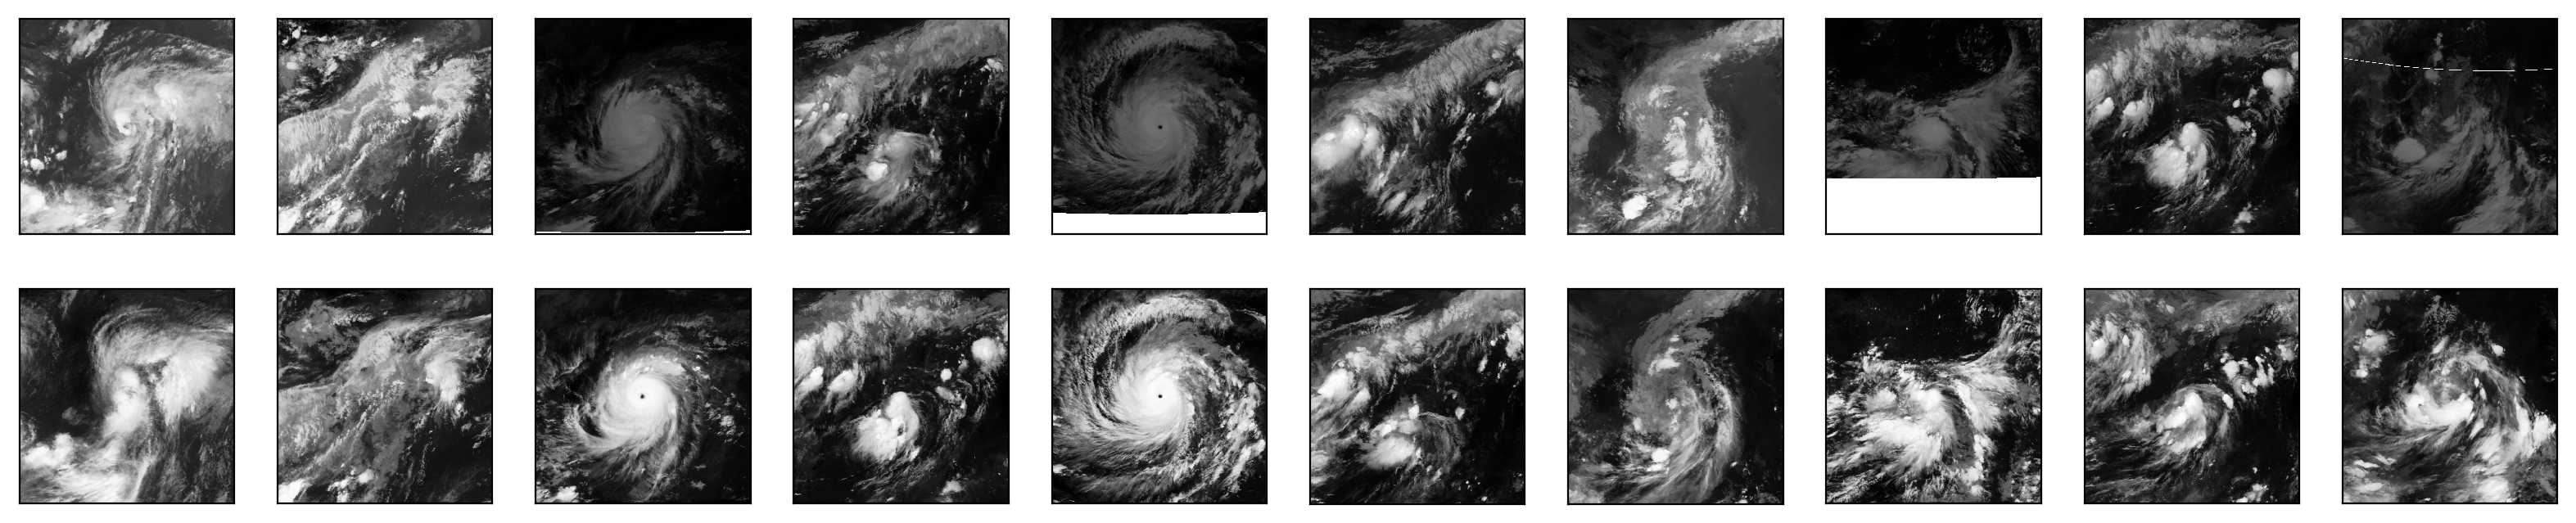

In [189]:
from os.path import join
n=10
seed = 1
images = binned.get_group(largest).sample(n=n, random_state=seed)
files = images.join(pd_man.images).loc[:, ['directory', 'filename']]
orig_images = [read_source_image(join(orig_images_dir, x[1].directory, x[1].filename)) for x in files.iterrows()]
corrected_images = [read_source_image(join(corrected_dir, x[1].directory, x[1].filename)) for x in files.iterrows()]

plt.figure(figsize=(20, 4), dpi=200)
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(orig_images[i], cmap="Greys")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display corrected
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(corrected_images[i], cmap="Greys")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.savefig(('correction{0}.png').format(seed))
plt.show()


In [197]:
orig_means = [x.mean() for x in orig_images]

In [198]:
orig_means

[266.00103379842375,
 267.48304650401309,
 267.45741495810313,
 259.22239782341006,
 228.26015282353907,
 259.62936511932372,
 276.66834762786863,
 192.31299211047585,
 261.22745601871486,
 263.22409367647367]

In [208]:
pix_vals = pd.DataFrame({'orig_mean':[x.mean() for x in orig_images],
                        'orig_min':[x.min() for x in orig_images],
                        'orig_max':[x.max() for x in orig_images],
                        'corr_mean':[x.mean() for x in corrected_images],
                        'corr_min':[x.min() for x in corrected_images],
                        'corr_max':[x.max() for x in corrected_images]})

In [237]:
pix_vals = pd.DataFrame()
for i in range(0, len(files)):
    pix_vals.loc[i, 'dir'] = files.iloc[i, 0]
    pix_vals.loc[i, 'file'] = files.iloc[i, 1]
    pix_vals.loc[i, 'orig_mean'] = orig_images[i].mean()
    pix_vals.loc[i, 'orig_min'] = orig_images[i].min()
    pix_vals.loc[i, 'orig_max'] = orig_images[i].max()
    pix_vals.loc[i, 'corr_mean'] = corrected_images[i].mean()
    pix_vals.loc[i, 'corr_min'] = corrected_images[i].min()
    pix_vals.loc[i, 'corr_max'] = corrected_images[i].max()


In [238]:
pix_vals

,dir,file,orig_mean,orig_min,orig_max,corr_mean,corr_min,corr_max
0,200004,2000070911-200004-GMS5-1.h5,266.001034,185.745553,316.235099,263.606937,190.144131,305.216228
1,199910,1999082506-199910-GMS5-1.h5,267.483047,191.960388,310.453924,268.634871,191.961424,301.893456
2,198722,1987112517-198722-GMS3-1.h5,267.457415,-14.230000,297.953436,269.033134,178.362110,297.226511
3,199502,1995060712-199502-GMS4-1.h5,259.222398,130.398000,292.723520,260.411022,162.243250,294.027420
4,199128,1991112704-199128-GMS4-1.h5,228.260153,-18.465000,298.724813,257.376093,181.752904,298.560487
5,199502,1995060802-199502-GMS4-1.h5,259.629365,130.398000,296.585070,260.763437,162.243250,292.292230
6,199609,1996080305-199609-GMS5-1.h5,276.668348,188.174280,313.819800,272.841510,188.044280,297.326440
7,198804,1988061908-198804-GMS3-1.h5,192.312992,-14.116000,298.896992,264.909439,185.535772,298.914523
8,199502,1995060701-199502-GMS4-1.h5,261.227456,130.398000,293.596130,261.682121,162.243250,293.596130
9,197908,1979073003-197908-GMS1-1.h5,263.224094,-20.321000,300.754300,263.739837,177.890911,296.992393


In [217]:
pix_vals.shape

(10, 6)